<a href="https://colab.research.google.com/github/ishandahal/stats453-deep_learning_torch/blob/main/Autoencoder/fully_connected_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fully connected Autoencoder on MNIST 
A simple, single-layer autoencoder that compresses 768-pixel MNIST images into 32-pixel vectors (32 times small) 

####IMPORTS

In [1]:
import time 
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Settings 

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device', device)

# hyperparameters 
random_seed = 123
learning_rate = 0.01
num_epochs = 15
batch_size = 256

# architecture
num_features = 784
num_hiddden_1 = 32

# MNIST Dataset

custom_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=custom_transform,
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=custom_transform)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,)

# checking the dataset 
for images, labels in train_loader:
    print(f"Feature batch dimensions {images.size()}")
    print(f"Label batch dimensions {labels.size()}")
    break

Device cpu
Feature batch dimensions torch.Size([256, 1, 28, 28])
Label batch dimensions torch.Size([256])


## Model

In [14]:
import torch.nn as nn
class Autoencoder(nn.Module):
    def __init__(self, num_features, num_hiddden_1):
        super().__init__()

        ## encoder 
        self.linear_1 = nn.Linear(num_features, num_hiddden_1)

        ## decoder
        self.linear_2 = nn.Linear(num_hiddden_1, num_features)

    def forward(self, x):

        # encoder 
        encoded = self.linear_1(x)
        encoded = F.leaky_relu(encoded)

        # decoder 
        logits = self.linear_2(encoded)
        decoded = torch.tanh(logits)

        return decoded

torch.manual_seed(random_seed)
model = Autoencoder(num_features, num_hiddden_1)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training

In [15]:
start_time = time.time()

for epoch in range(num_epochs):
    for batch_idx, (features, labels) in enumerate(train_loader):

        ## don't need labels
        features = features.view(-1, 28*28).to(device)

        # forward and back prop
        decoded = model(features)
        cost = F.mse_loss(decoded, features)
        optimizer.zero_grad()

        cost.backward()

        # update model parameters
        optimizer.step()

        # logging
        if not batch_idx % 50:
            print(f"Epoch: {epoch + 1:03d}/{num_epochs:03d} | Batch {batch_idx + 1:03d}/{len(train_loader):03d} | "
                  f"Cost: {cost:.4f}")
    
    print(f"Time elapsed: {(time.time() - start_time)/60:.2f} min")

print(f"Total time elapsed: {(time.time() - start_time)/60:.2f} min")

Epoch: 001/015 | Batch 001/235 | Cost: 0.9985
Epoch: 001/015 | Batch 051/235 | Cost: 0.2069
Epoch: 001/015 | Batch 101/235 | Cost: 0.1671
Epoch: 001/015 | Batch 151/235 | Cost: 0.1487
Epoch: 001/015 | Batch 201/235 | Cost: 0.1331
Time elapsed: 0.19 min
Epoch: 002/015 | Batch 001/235 | Cost: 0.1287
Epoch: 002/015 | Batch 051/235 | Cost: 0.1146
Epoch: 002/015 | Batch 101/235 | Cost: 0.1071
Epoch: 002/015 | Batch 151/235 | Cost: 0.0963
Epoch: 002/015 | Batch 201/235 | Cost: 0.0902
Time elapsed: 0.38 min
Epoch: 003/015 | Batch 001/235 | Cost: 0.0879
Epoch: 003/015 | Batch 051/235 | Cost: 0.0831
Epoch: 003/015 | Batch 101/235 | Cost: 0.0805
Epoch: 003/015 | Batch 151/235 | Cost: 0.0786
Epoch: 003/015 | Batch 201/235 | Cost: 0.0747
Time elapsed: 0.57 min
Epoch: 004/015 | Batch 001/235 | Cost: 0.0725
Epoch: 004/015 | Batch 051/235 | Cost: 0.0738
Epoch: 004/015 | Batch 101/235 | Cost: 0.0675
Epoch: 004/015 | Batch 151/235 | Cost: 0.0654
Epoch: 004/015 | Batch 201/235 | Cost: 0.0663
Time elapse

## Evaluation 

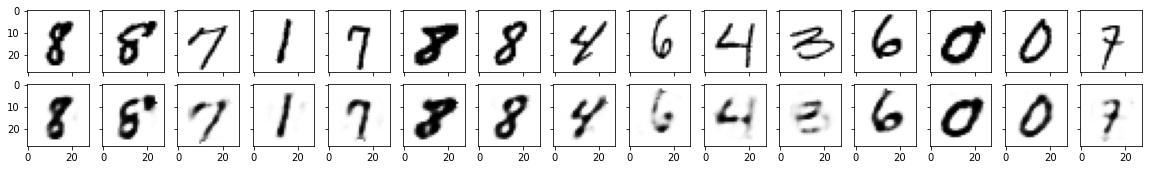

In [21]:
import matplotlib.pyplot as plt

# visualization 

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images,
                         sharex=True, sharey=True, figsize=(20, 2.5))

orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')
